### Introduction

Using a well-known and clean dataset containing cancer diagnoses, I'll implement and evaluate a dense Neural Network using Keras.

The neural network is basic and quick, but the purpoes of this flash challenge was to quickly apply and compare two completely different machine learning workflows.

### Imports

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import scikitplot as skplt

import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.utils import to_categorical
from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook, tnrange

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, precision_recall_curve, auc, roc_curve)
from sklearn.metrics import cohen_kappa_score

Using TensorFlow backend.


### Quick exploration

In [2]:
data = pd.read_csv('../data/cancer_data.csv')

data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Preprocessing

In [3]:
#X/Y - Leave out the ID column and the garbage column at the end
X = data.iloc[:, 2:-1]
y = data.iloc[:, 1]

In [4]:
#Relabel M/B to 1/0. Alternately, use sklearn's LabelEncoder
y = np.where(y == 'M', 1, 0)

In [5]:
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)

In [6]:
#Scale after splitting to prevent information leakage
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [7]:
#Convert Y to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test)

### Neural Network

In [8]:
#Preset epochs and batch size
epochs=100
batch_size = 32

In [9]:
#Straightforward and quick!
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(30, )))
model.add(Dense(2, activation='sigmoid', input_shape=(30, )))



model.compile(loss='binary_crossentropy',
                optimizer='sgd',
                metrics=['accuracy'])

In [10]:
#Fit the model
history = model.fit(X_train, y_train_cat, 
                   batch_size=batch_size, 
                   epochs=epochs,
                   verbose=0, 
                   callbacks=[TQDMNotebookCallback()],
                   validation_data=(X_test, y_test_cat))

### Results and evaluation

In [11]:
#Model score on the test set
score=model.evaluate(X_test, y_test_cat)

171/171 [==============================] - ETA:  - 0s 49us/step


In [12]:
print('Test loss: {:.3f}'.format(score[0]))
print('Test accuracy: {:.3f}'.format(score[1]))

Test loss: 0.097
Test accuracy: 0.980


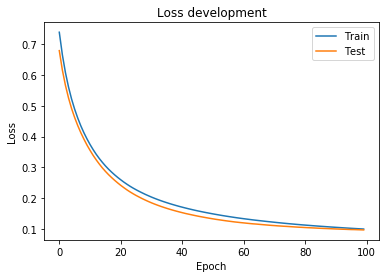

In [13]:
def plot_epoch_loss(logs, name):
    hist = logs.history
    plt.plot(logs.epoch, hist['loss'], label='Train')
    plt.plot(logs.epoch, hist['val_loss'], label='Test')
    plt.title('Loss development')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../img/{}.png'.format(name))
plot_epoch_loss(history, name='Loss development by epoch')

In [14]:
#Use our model to predict classes for the test data
ypred = model.predict_classes(X_test)

C:\Users\youri\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


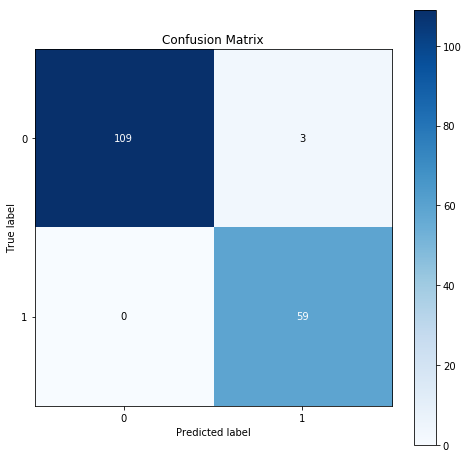

In [15]:
#Confusion Matrix
fig, ax = plt.subplots(figsize=(8,8))
skplt.metrics.plot_confusion_matrix(y_test, ypred, ax=ax)
plt.savefig('../img/confusion_matrix.png')
None

Immediately, we see the highly encouraging sign that the model has perfect recall. When a tumor is malignant (a score of 1), the model never categorizes it a benign (a score of 0).

In [16]:
#How many did we get wrong, in total?
print("Number of misdiagnoses on the test data: {}".format(len(ypred[ypred != y_test])))
#How much does our model outperform randomness?
print("Cohen kappa score: {:.3f}".format(cohen_kappa_score(y_test, ypred)))

Number of misdiagnoses on the test data: 3
Cohen kappa score: 0.962


In [17]:
#Classification Report
print(classification_report(y_test, ypred))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99       112
          1       0.95      1.00      0.98        59

avg / total       0.98      0.98      0.98       171



Metrics look great across the board. The recall of 1 is exactly what we're looking for in this dataset; misdiagnosing a malignant tumor as benign would be disastrous. This, fortunately, did not come at the cost of a high rate of false positives, which is futher visible in the ROC curve below. Note the high AUC-score.

Area Under Curve: 0.987


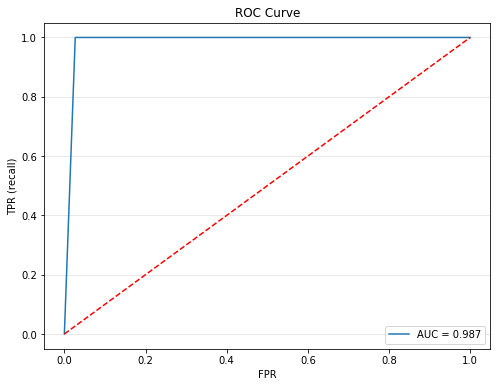

In [18]:
#ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_test, ypred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(fpr,tpr, label='AUC = {:.3f}'.format(roc_auc))
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR (recall)")
ax.plot([0,1],[0,1],'r--')
ax.yaxis.grid(color='lightgrey', lw=0.5)
ax.set_axisbelow(True)
plt.legend()
plt.savefig('../img/roc-curve.png')
None
print("Area Under Curve: {:.3f}".format(roc_auc))